In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
from highlight_text import htext
from PIL import Image
import os

Useful function reset matplotlib parameters before creating a new figure

In [2]:
def reset_matplotlib():
    plt.rcParams.update(plt.rcParamsDefault)

Get back to the root of the ipl_vizs repo

In [3]:
root_path = '/'.join(os.getcwd().split('/')[:-1])

Define some key plotting parameters which we will use again and again, mainly around fonts and styling

In [4]:
title_font = 'Din Alternate'
main_font = "Gill Sans"
text_colour = 'w'
outline_colour = 'w'
background_colour =  '#96afd9'
title_font_size = 20
subtitle_font_size = 10
logo_path = root_path + '/images/logo.png'
highlight_colour = 'grey'

Open team_info xls, holds lots of information like colour codes for the individual teams

We create a dictionary with keys as the team names so we can look up other features if we need them

In [5]:
team_info = pd.read_excel(root_path+ '/team_data/team_info.xlsx')
team_info = team_info.set_index('team').to_dict()

Open up all the files in the folder, i.e. all the ball by ball data we have and concat into one dataframe

In [6]:
all_data_lst = []
folder_path = root_path+'/ball_by_ball_data/ipl/'

for filename in os.listdir(folder_path):
    df = pd.read_csv(folder_path+filename)
    all_data_lst.append(df)

df = pd.concat(all_data_lst)

Import the squad lists from each season of the IPL

In [7]:
squads_folder_path = root_path+'/team_data/ipl_squads.csv'
ipl_squads = pd.read_csv(squads_folder_path)

Brief bit of data cleaning to replace the Rising Pune Supergiant values

In [8]:
df['team'] = np.where(df['team']=='Rising Pune Supergiant', 'Rising Pune Supergiants', df['team'])

For each game, for each batter, find the minimum value in the innings_balls column, i.e. the first ball they faced in the innings, how far through the 120 was it?

In [9]:
min_inns_balls = df.groupby(['batter','team','match_id','year'], as_index=False).agg({'innings_balls':'min'})

Now we average this for each player, over a season

We also count the match_id column to find the number of games they played that year

In [10]:
min_balls = min_inns_balls.groupby(['batter','team','year'], as_index=False).agg({'innings_balls':'mean','match_id':'count'})

A common styling function

In [11]:
def format_vt20_graphs(fig, ax):
    fig.set_facecolor(background_colour)
    ax.patch.set_facecolor(background_colour)
    plt.xticks(c=text_colour, fontfamily=main_font, fontsize=8, fontweight='bold')
    plt.yticks(c=text_colour, fontfamily=main_font, fontsize=8, fontweight='bold')
    ax.tick_params(axis='both', colors=text_colour)
    spines = ["top","right","bottom","left"]
    for s in spines:
        if s in ["top","right"]:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

    return fig, ax

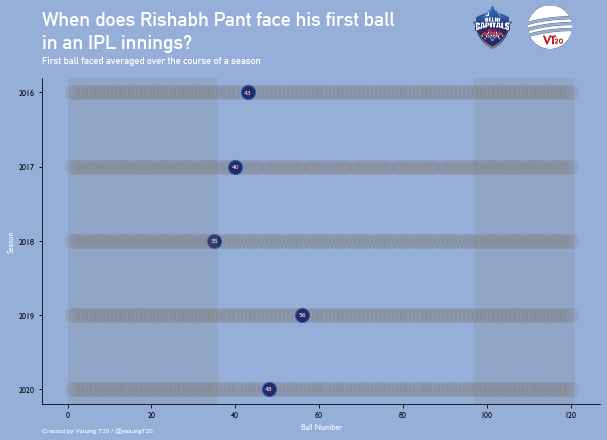

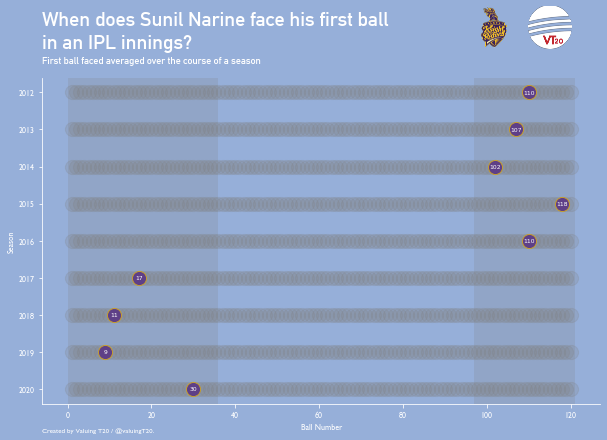

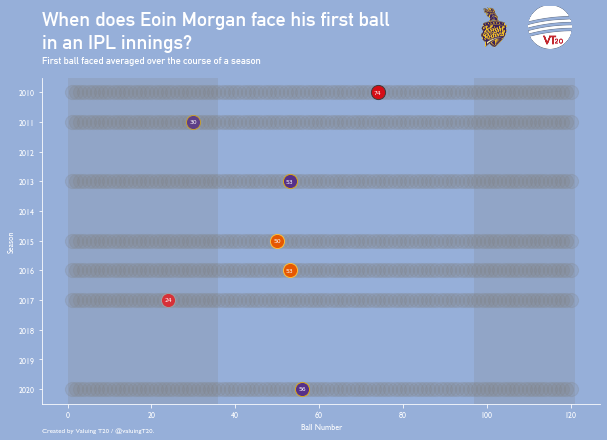

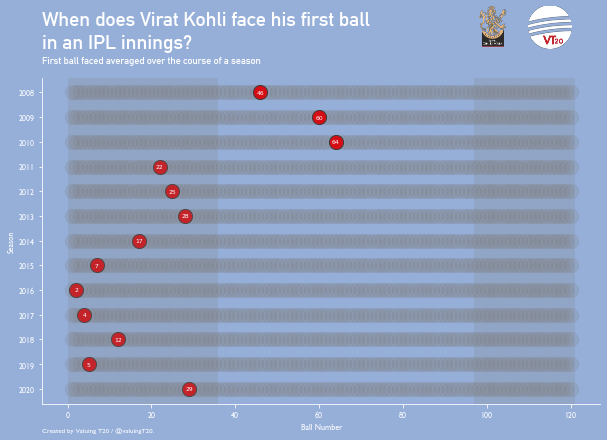

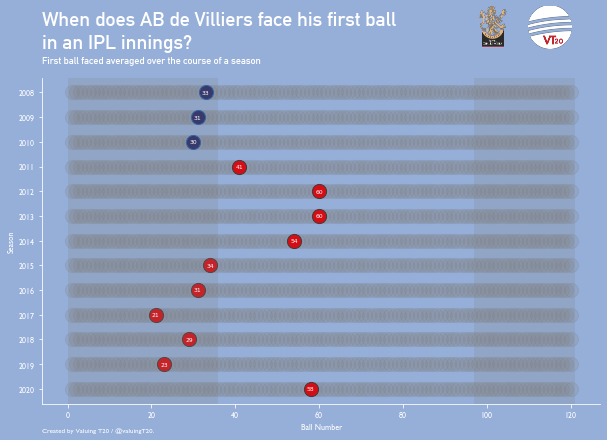

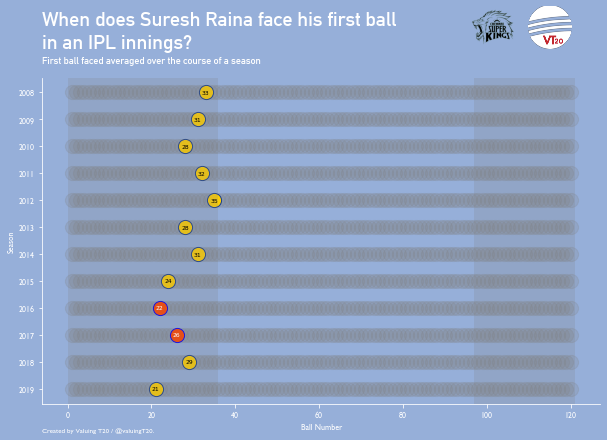

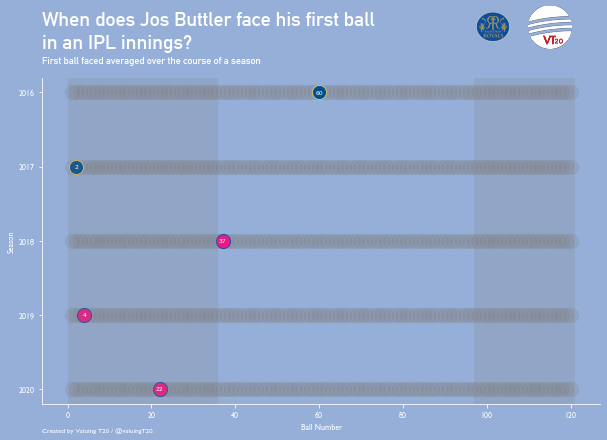

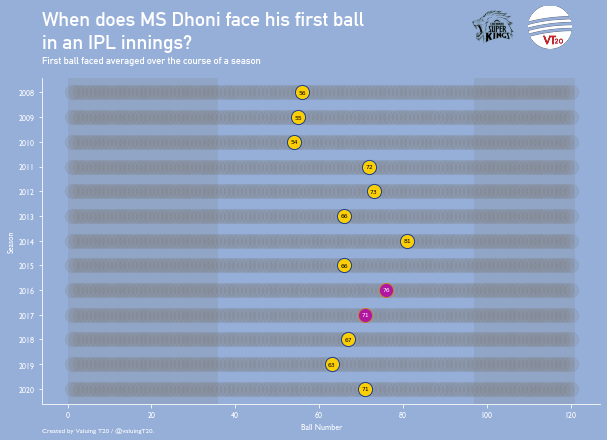

In [17]:
for player in ['Rishabh Pant', 'Sunil Narine', 'Eoin Morgan','Virat Kohli', 'AB de Villiers', 'Suresh Raina','Jos Buttler','MS Dhoni']:
    player_lower = player.lower().replace(' ','_')

    plot_df = min_balls.loc[min_balls['batter'] == player].set_index('year')
    team = ipl_squads.loc[ipl_squads['name'] == player].sort_values('year').iloc[-1]['team']
    team_lower = team.lower().replace(' ','_')

    # Remove the decimal places by having the innings_balls number as an integer, not a float
    plot_df['innings_balls'] = plot_df['innings_balls'].astype('int')

    plot_df['c'] = plot_df['team'].apply(lambda x: team_info['primary_colour'].get(x))
    plot_df['c2'] = plot_df['team'].apply(lambda x: team_info['second_colour'].get(x))

    # We want to plot a dot for all 120 dots in the innings
    balls = range(1,121)

    fig, ax = plt.subplots(figsize=(10,6))
    fig, ax = format_vt20_graphs(fig, ax)

    s=200

    c = team_info['primary_colour'].get(team)
    c2 = team_info['second_colour'].get(team)

    # We plot a second dot on the average ball on which they started their innings, in the team's colours
    for index, row in plot_df.iterrows():
        ax.scatter(y=[index]*120, x=balls, c='grey', zorder=1, alpha=0.2, s=s, edgecolors=None)
        ax.scatter(y=index, x=row['innings_balls'], edgecolors=row['c2'], c=row['c'], s=s)

        # If we are plotting a CSK yellow dot, we want black text as it stands out better
        if plot_df.loc[year,'c'] == '#FCCE05':
            text_colour = 'black'
        else:
            text_colour = 'white'

        # Write the ball number as a string over the dot
        ax.text(y=year, x=plot_df.loc[year,'innings_balls'], s=plot_df.loc[year,'innings_balls'], ha='center', va='center',fontsize=6, c=text_colour)

    ax.axvspan(0, 6*6, color=highlight_colour, alpha=0.2, lw=0)
    ax.axvspan((16*6)+1, 121, color=highlight_colour, alpha=0.2, lw=0)

    ax2 = fig.add_axes([0.78,0.945,0.1,0.1]) # badge
    ax2.axis("off")
    img = Image.open(logo_path)
    ax2.imshow(img)

    team_logo = root_path+'/images/team_logos/ipl/' + team_lower + '.png'
    ax3 = fig.add_axes([0.7,0.945,0.1,0.1]) # badge
    ax3.axis("off")
    img = Image.open(team_logo)
    ax3.imshow(img)

    htext.fig_text(x = 0.125, y = 0.94,
                            s = f'When does {player} face his first ball\nin an IPL innings?'
                            , color = text_colour
                            , fontsize=title_font_size
                            , fontfamily=title_font
                            , fontweight='bold')

    htext.fig_text(x = 0.125, y = 0.91,
                        s = f"First ball faced averaged over the course of a season"
                        , color = text_colour
                        , fontsize=subtitle_font_size
                        , fontfamily=title_font
                        , fontweight='bold')

    ax.set_ylabel(f'Season', c=text_colour, fontfamily=main_font, fontsize=8)
    ax.set_xlabel('Ball Number', c=text_colour, fontfamily=main_font, fontsize=8)

    ax.set_yticks(range(min(plot_df.index), max(plot_df.index)+1))

    fig.text(0.125, 0.06, f"Created by Valuing T20 / @valuingT20.",
                fontstyle="italic",fontsize=7, fontfamily=main_font, color=text_colour)

    ax.invert_yaxis()

    # Save image to folder
    fig.savefig(root_path + f'/outputs/innings_starting_balls/{player_lower}.jpg', facecolor=fig.get_facecolor(), dpi=500, bbox_inches = 'tight')